### MULTIMESSENGER DATA ANALYSIS IN THE ERA OF CTA - Sexten 2019
# Hands-on session on GW data

#### Compiled by M. Razzano (University of Pisa & INFN-Pisa) - Last revision June 21, 2019


### Introduction
This is a *very short and introductory* notebook that shows somebasic operations to read and manipulate gravitational wave data. This tutorial uses the datasets provided by the Gravitational Wave Open Science Center (GWOSC), that can be accessed [here](https://www.gw-openscience.org/).
This tutorial will cover the following topis
* Reading GW data
* Exploring and plotting data
* Basic data filtering
* Using matched filter to detect GW signal from compact binary coalescence (CBC)

In this Tutorial we will use the following Python packages:

* [gwpy](https://gwpy.github.io/)
* [pyCBC](https://pycbc.org)

The code of this tutorial is based and partly extracted from a more comprehensive set of tutorials organized by the GWOSC team of the LIGO and Virgo collaborations. For more information, please refer to the Open Data Workshops organized by the LIGO and Virgo collaboration, eg. [Open Data Workshop 2019](https://indico.in2p3.fr/event/18313/overview). 

### Basic Setup
Here we will import the basic Python packages

In [6]:
#basic imports
import os, sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

#We can also extract some env variables that points to the data and work directory
#Setup the main directories using the environ dir
project_dir = os.environ["PROJECT_MAIN_DIR"]
data_dir = os.environ["PROJECT_DATA_DIR"]

print("Project main dir is %s" % project_dir)
print("Data dir is %s" %data_dir)


work_dir = os.environ["PROJECT_WORK_DIR"]
if not os.path.exists(work_dir):
    os.mkdir(work_dir)
    print("Created work dir %s" %work_dir)
print("Work dir is %s" %work_dir)

Project main dir is /datawin/University/OrganizzazioneConferenze/2019SextenCTA/gw-sexten2019
Data dir is /datawin/University/OrganizzazioneConferenze/2019SextenCTA/gw-sexten2019/data
Work dir is /home/razzano/gw-handson


### Explore the GW events on GWOSC
With the gwosc package you can read directly from the GWOSC website and list the events that are available!
And of course, retrieve the data

In [7]:
#explore the events in the dataset
from gwosc.datasets import find_datasets
events = find_datasets(type="event")
print(events)

['151008', '151012A', '151116', '161202', '161217', '170208', '170219', '170405', '170412', '170423', '170616', '170630', '170705', '170720', 'GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729', 'GW170809', 'GW170814', 'GW170817', 'GW170818', 'GW170823']


In [8]:
#We can also find some information about a particular event, such as the GPS time or the URL
from gwosc.datasets import event_gps
from gwosc.locate import get_event_urls

ev_name = "GW150914"

ev_gps = event_gps(ev_name)
event_urls = get_event_urls(ev_name)

print("%s,%.1f,%s" % (ev_name,ev_gps,event_urls))

GW150914,1126259462.4,[u'https://www.gw-osc.org/catalog/GWTC-1-confident/data/GW150914/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5', u'https://www.gw-osc.org/catalog/GWTC-1-confident/data/GW150914/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5', u'https://www.gw-osc.org/catalog/GWTC-1-confident/data/GW150914/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5', u'https://www.gw-osc.org/catalog/GWTC-1-confident/data/GW150914/L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5']


### Read the data from GWOSC
Using gwpy it is possible to read the data directly from GWOSC, using the *fetch_open_data* command

In [10]:
from gwpy.timeseries import TimeSeries
from gwpy.segments import DataQualityFlag


#interferometer to use
ev_ifo = "H1"


# Select 512 seconds around the event
dt_win=256
ev_t0_min = ev_gps-dt_win
ev_t0_max = ev_gps+dt_win

print("Get data for %s (%s) GPS: %.2f - %.2f" % (ev_name,ev_ifo,ev_t0_min,ev_t0_max))
    
#fetch the data. Use cache=True to keep the data in the cache memory (to speed things up)
data = TimeSeries.fetch_open_data(ev_ifo,ev_t0_min,ev_t0_max,cache=True)

#get the segments in a larger time window (just to have a bigger time span to look over)
segments = DataQualityFlag.fetch_open_data(ev_ifo+"_DATA",ev_t0_min-3600,ev_t0_max+3600)
print("Done")

Get data for GW150914 (H1) GPS: 1126259206.40 - 1126259718.40
Done


### Read the data from a local file
Actually, using gwpy you can also read the data from a local file, that usually is available in HDF5 format.

In [16]:
h1_filename = "H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5"
h1_filename = os.path.join(data_dir,h1_filename)
print("reading file %s" % h1_filename)

local_data = TimeSeries.read(h1_filename,format='hdf5.losc')

print("Done")

reading file /datawin/University/OrganizzazioneConferenze/2019SextenCTA/gw-sexten2019/data/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5
Done


### Quicklook at the data in the time domain
With gwpy you can plot the timeseries and apply some basic filtering

/usr/programs/miniconda2/envs/gw-env-py27/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


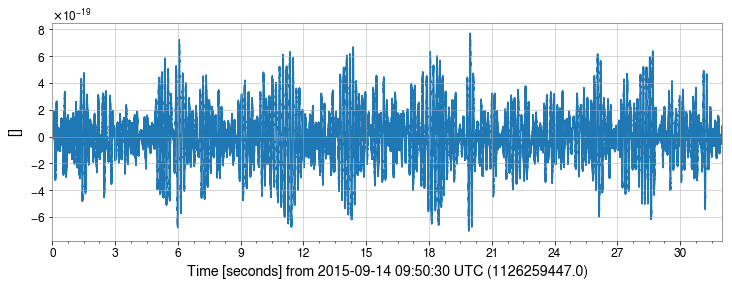

In [17]:
from gwpy.plot import Plot

#Plot raw data   
plot_data=data.plot()
plot_data.show()

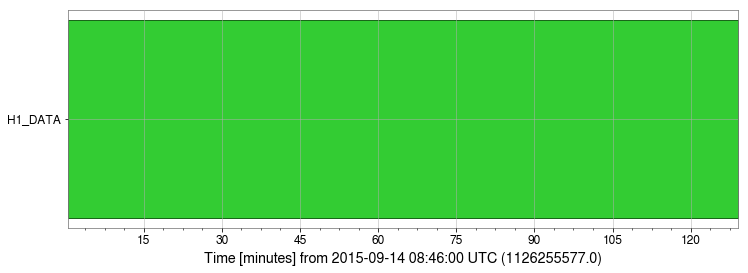

In [19]:
#plot segments to check the data quality
plot = segments.plot()

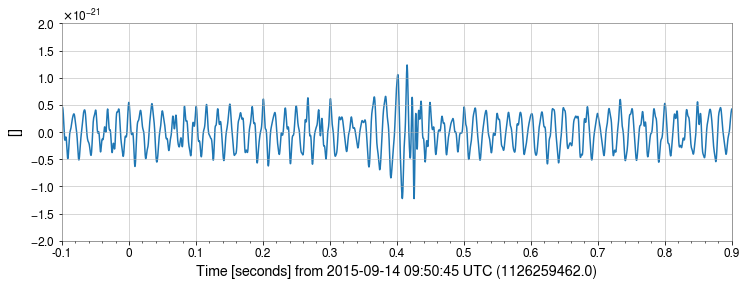

In [20]:
#We can then bandpass, e.g. from 50 to 250 Hz

#plot filtered data
data_filtered=data.bandpass(50,250)

plot = data_filtered.plot()
ax = plot.gca()

#zoom around the event. Can we see something now?
ax.set_xlim(ev_gps-0.5,ev_gps+0.5)
ax.set_ylim(-0.2e-20,0.2e-20)
plot.refresh()

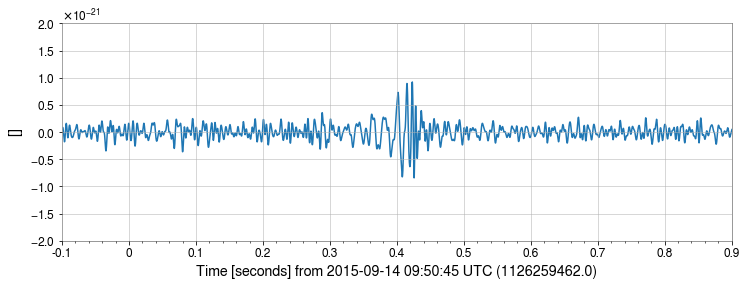

In [22]:
#and we can notch around the 60 Hz utility line
data_filtered=data_filtered.notch(60)

plot = data_filtered.plot()
ax = plot.gca()

#zoom around the event. Can we see something now?
ax.set_xlim(ev_gps-0.5,ev_gps+0.5)
ax.set_ylim(-0.2e-20,0.2e-20)
plot.refresh()

### Look at the data in the frequency domain
We can also look at the data in the frequency domain, and build and plot the Amplitude Spectral Density

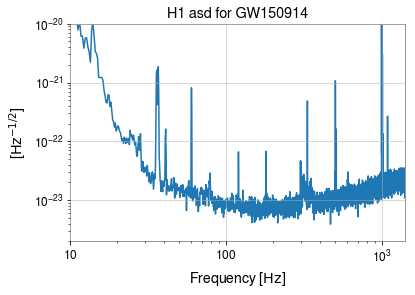

In [23]:
#Now we can plot the ASD as well, using the Welch method with a overlapping window of 4 seconds

asd = data.asd(fftlength=4, method="median")
plot = asd.plot()

ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(2e-24, 1e-20)
ax.set_title(ev_ifo+ " asd for "+ev_name)
plot.refresh()

### Matched filtering and detection
The matched filter represents the optimal way to detect a gravitational wave signal for which we know the waveform. This is the case, for instance, of the compact binary coalescence, where the waveforms can be computed from general relativity. To be optima, the matched filter should operate in a regime where the noise is gaussian and stationary.
For this part we will use the pyCBC package.

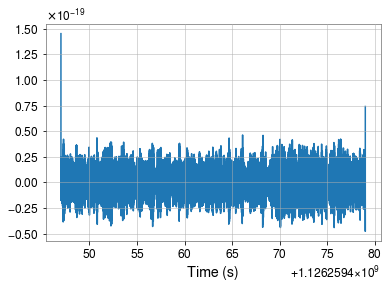

In [29]:
import pylab
from pycbc.filter import resample_to_delta_t, highpass

# Convert the data from gwpy to pyCBC format
strain = data.to_pycbc()

# We then removethe frequencies below 15 Hz and downsample data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

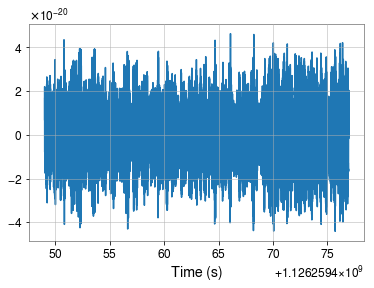

In [30]:
# There are ringing artifacts at the borders, so we can remove the 2 seconds from both the beginning and end
conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [31]:
#To build the matched filter, we need the Power Spectral Density, i.e. the square of the ADS. We will compute it now using pyCBC

from pycbc.psd import interpolate, inverse_spectrum_truncation


# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, 4 * conditioned.sample_rate,
                                  low_frequency_cutoff=15)

Text(0,0.5,'Strain')

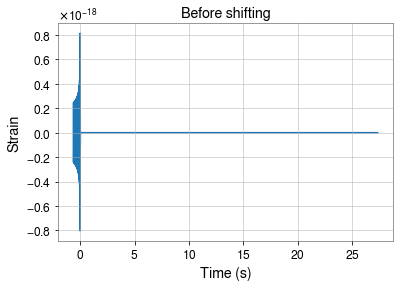

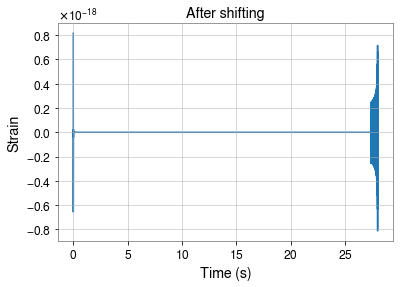

In [33]:
from pycbc.waveform import get_td_waveform
# In this case we start from a value of the mass that we know already. In real life, the search pipelines will
# search of a parameter space of masses and spins, and for each set of values will compute a waveform and evaluate
# the SNR of the matched filter

# We will assume equal masses, and non-rotating black holes, which is within the posterior probability
# of GW150914. 

m_guess = 35 # Solar masses, of course

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m_guess,
                     mass2=m_guess,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# The cyclic_time_shift method shifts the timeseries by a given amount of time.
# It treats the data as if it were on a ring so points shifted off the end
# of the series reappear at the start. Note that time stamps are *not* in
# general affected (as the start time of the full array is shifted),
# but the index of each point in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

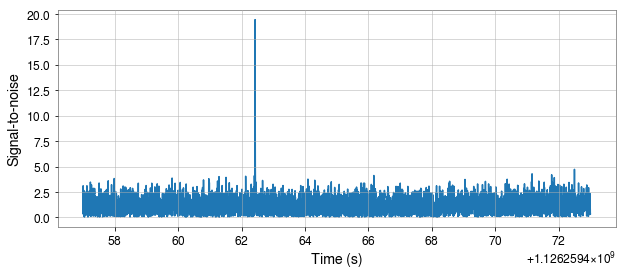

We found a signal at 1126259462.43s with SNR 19.405620685


In [34]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

### Comparing the data and the template
Once that the matched filter has been used to detect the signal, we can compare the filtered data and the template

In [36]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

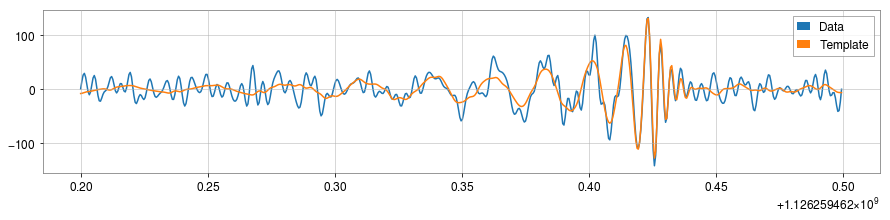

In [37]:
# Once the data have been shifted and rescaled, we can whiten them

white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(ev_gps-.2, ev_gps+.1)
white_template = white_template.time_slice(ev_gps-.2, ev_gps+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

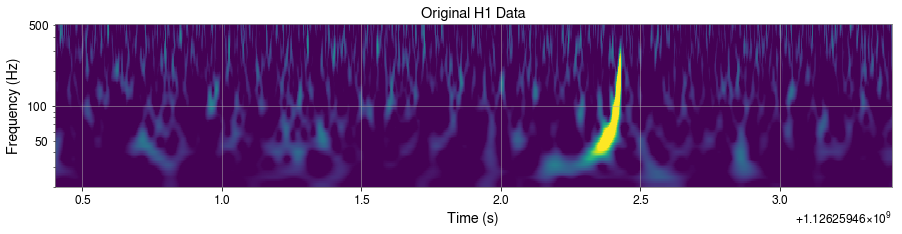

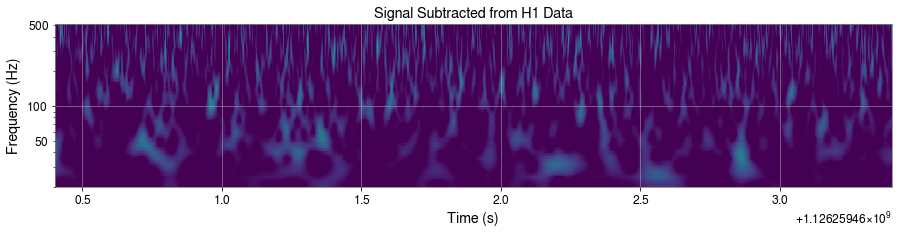

In [38]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                           logfsteps=100,
                                           qrange=(8, 8),
                                           frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(ev_gps - 2, ev_gps + 1)
    pylab.show()